# Method: RC 
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction of Small Dataset

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import sparse

import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax.numpy import tanh
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [22]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [23]:
train.data = train.data[:13500]
train.time = train.time[:13500]

In [24]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (13500, 40)
Test size: (90000, 40)


**Create test set**

In [25]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [26]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [27]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RC Implementation

In [28]:
def get_parameters(nn_size, connectivity, spec_radius, lambd, 
                   seed, batch_size, num_epoch, lr_schedule = [1e-4], 
                   early_stopping = EARLY_STOPPING):
    """
    Returns trained parameters (beta, intercept) and hidden layer values
    """
    def initialize_coef():
        """
        Initializes W_in and W. 
        W_in size = nn_size x data_dim
        W size = nn_size x nn_size
        """
        start = time()

        # Generate input -> hidden unit weights
        W_in = 2 * (np.random.rand(nn_size, data_dim) - 0.5) 
        W_in = W_in / (4 * np.sqrt(data_dim))

        # Generate hidden -> hidden unit weights
        # Considers connectivity to make the matrix sparse
        start_mat = time()
        rows = np.concatenate([np.full(connectivity, i) for i in range(nn_size)])
        cols = np.concatenate([np.random.choice(range(nn_size), size = connectivity, replace = False) for _ in range(nn_size)])
        vals = np.random.uniform(low = -omega, high = omega, size = (nn_size * connectivity))
        W = sparse.csr_matrix((vals, (rows, cols)), shape = (nn_size, nn_size))
        end_mat = time()
        print(f"W generated. Time taken: {end_mat - start_mat:.2f}s")

        # Calculate eigenvalues for scaling of matrix
        print("Calculating eigenvalue")
        e_start = time()
        eigenvals = sparse.linalg.eigs(W, which = "LM", return_eigenvectors = False, k = 1)
        max_eigen = np.abs(eigenvals)
        e_end = time()
        print(f"Eigenvalue calculated. Time taken: {e_end - e_start:.2f}s")

        # Scale matrix by spectral radius
        W = W / max_eigen * spec_radius # scale the matrix W by its spectral radius
        W = sparse.csr_matrix(W)
        
        end = time()
        print(f"W and W_in generated. Time taken: {end-start:.2f}s")
        print()
        
        return W_in, W
    
    def generate_hidden_states(W_in, W):
        """ 
        Generate hidden states (z) values
        hidden_states size = data_size x nn_size 
        """
        start = time()
        
        print("Generating z values...")
        indiv_z = np.zeros(shape = nn_size)
        hidden_states = np.zeros((train_size, nn_size))
        
        for t in range(train_size):  
            indiv_z = (1 - alpha) * indiv_z + \
                alpha * np.tanh(W_in @ x[t] + W @ indiv_z)
            hidden_states[t, :] = indiv_z
        end = time()
        print(f"z values generated. Time taken: {end-start:.2f}s")
        
        return hidden_states
    
    def mse(y, y_pred):
        return jnp.mean((y_pred - y)**2)
    
    @jax.jit
    def mse_loss(params, x, y):
        """
        returns mean squared error
        """
        beta, intercept = params
        pred = x @ beta + intercept
        return mse(pred, y) + np.mean(beta**2) * lambd / 2 + np.mean(intercept**2) * lambd / 2
    
    def validation_loss(params, x_val, y_val):
        beta, intercept = params
        num_data_test, trans, data_dim = x_val.shape # testing ex, # steps used (transient), dim of data

        def prediction(inp):
            """
            Returns the mean of one of the testing input

            mean will be a length_to_test x data_dim vector
            """
            z = np.zeros((nn_size // 2, ))
            for i in range(trans):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)

            mus = []
            stddevs = []

            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
            mus.append(x)

            for _ in range(L_forecast_test - 1):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
                x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
                mus.append(x)

            return mus

        mean_list = []
        sd_list = []

        for i in range(num_data_test):
            pred = prediction(x_val[i])
            mean_list.append(pred)

        return mse(mean_list, y_val)

    def training(x, y):
        """ 
        Trains regression of y~x using SGD. 
        Returns parameters (beta, intercept) where 
        beta, intercept -> weights to determine the mean
        
        beta size = nn_size x data_dim
        intercept = data_dim (will be added for each training data)
        
        should predict a mu with train_size x data_dim (\mu per dimension per datapoint)
        and a sigma with train_size x 1 (single \sigma for all dimensions per datapoint)
        """
        
        @jax.jit
        def step(opt_state, x, y):
            params = get_params(opt_state)
            value, g = value_and_grad(mse_loss)(params, x, y)
            opt_state = opt_update(0, g, opt_state)
            return get_params(opt_state), opt_state, value

        start = time()
        
        # Plot loss
        loss_train_traj = []
        loss_train_all_traj = []
        
        # Init parameters
        beta = np.random.normal(0, 1 / np.sqrt(nn_size), size = (nn_size, data_dim))
        intercept = np.random.normal(0, 1 / np.sqrt(nn_size * 2), size = (data_dim, ))
        
        t_size = int(1. * train_size)
        
        overall_best_mse = 9999999
        
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init([beta, intercept])
            
            # For early stopping
            best_state = opt_state
            counter = 0 
            best_val_loss = 9999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                T_indices = np.arange(train_size)
                np.random.shuffle(T_indices)

                loss_epoch_train = []
                for k in range(t_size // batch_size + 1):
                    t_start = T_indices[np.arange(k * batch_size, (k+1) * batch_size).astype(int) % len(T_indices)]
                    x_batch = x[t_start]
                    y_batch = y[t_start]

                    params, opt_state, l = step(opt_state, x_batch, y_batch)
                    loss_epoch_train.append(l)
                
                
                loss_train_all_traj += loss_epoch_train
                mse_train = np.mean(loss_epoch_train)
                loss_train_traj.append(mse_train)
                
                e_end = time()
                
                if mse_train < best_val_loss:
                    best_val_loss = mse_train
                    counter = 0
                    best_state = opt_state
                else:
                    counter += 1
                    
                if (epoch + 1) % 20 == 0:
                    print(f"Epoch {epoch + 1}: Train time = {e_end - e_start:.2f} | Train Loss = {mse_train:.7f}", end = " ")
                    print()
                if counter == early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f}")
                    break
            
            print(f"Best Training MSE: {best_val_loss:.7f}") 
            
            if best_val_loss < overall_best_mse:
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_val_loss
                overall_best_state = best_state
            
            beta, intercept = get_params(overall_best_state)
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return get_params(overall_best_state) # beta, intercept
    
    start = time()
   
    x, y = train.data[:-1], train.data[1:]
    copy_x, copy_y = x, y 
    train_size, data_dim = x.data.shape
       
    np.random.seed(seed)
    W_in, W = initialize_coef()
    z = generate_hidden_states(W_in, W)

    # Want to regression Y ~ X ==> Y ~ [z, z**2]
    final_y = y[transient:]
    final_z = z[transient:]
    print("Concatenating z with z**2", end = " "); concat_start = time()
    final_z = np.concatenate([final_z, final_z**2], axis = 1) # shape: train_size x (nn_size*2)
    concat_end = time()
    print(f"Contenation complete. Time taken: {concat_end-concat_start:.2f}s", end = "\n\n")
    
    train_size, nn_size = final_z.shape
    
    params = training(final_z, final_y)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return params, (final_z, W_in, W)

In [29]:
def get_test_pred(data_test, nn_size, params, W_in, W):   
    beta, intercept = params
    num_data_test, trans, data_dim = data_test.shape # testing ex, # steps used (transient), dim of data
    
    def prediction(inp):
        """
        Returns the mean of one of the testing input
        
        mean will be a length_to_test x data_dim vector
        """
        
        z = np.zeros((nn_size, ))
        for i in range(trans):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)
        
        mus = []
        stddevs = []
        
        x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
        mus.append(x)
        
        for _ in range(L_forecast_test - 1):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
            mus.append(x)
        
        return mus
    
    start = time()
    
    mean_list = []
    sd_list = []
    
    for i in range(num_data_test):
        pred = prediction(data_test[i])
        mean_list.append(pred)

        if (i+1) % 10 == 0:
            print(f"{(i+1) / num_data_test * 100:.2f}% done")
    
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mean_list)

# 3. Parameter tuning

There are 4 parameters to tune
- nn_size [3000, 6000, 9000, 12000, 150000] - size of the hidden layer
- connectivity [4, 8] - sparseness of W
- spec_radius [0.1, 0.3, 0.5, 0.7] - spectral radius (scale) of W
- lambda [1e-2, 1e-4, 1e-6] - ridge regression penalty

Through initial expeirments, it was shown that the value of lambda does not greatly affect the results. As a full grid search will be computationally expensive, nn_size is first tuned. Then, a lambda value is chosen, followed by the spectral radius and lastly, the optimal connectivity.

## 3.1 nn_size

**Parameters**
- nn_size = [3000, 6000, 9000, 12000, 15000]
- connectivity = 4
- spec_radius = 0.5 
- lambda = 1e-4

In [30]:
ridge_penalty = 1e-4
connectivity = 4
spec_radius = 0.5
transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

### 3.1.1 nn_size = 3000

In [31]:
nn_size = 3000
lr_list = [1e-4]
epoch_list = [400]

In [32]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 1.33s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 0.41s
W and W_in generated. Time taken: 2.06s

Generating z values...
z values generated. Time taken: 2.30s
Concatenating z with z**2 Contenation complete. Time taken: 0.44s

Epoch 20: Train time = 0.33 | Train Loss = 0.0013726 
Epoch 40: Train time = 0.34 | Train Loss = 0.0005259 
Epoch 60: Train time = 0.34 | Train Loss = 0.0002301 
Epoch 80: Train time = 0.33 | Train Loss = 0.0001093 
Epoch 100: Train time = 0.33 | Train Loss = 0.0000564 
Epoch 120: Train time = 0.34 | Train Loss = 0.0000319 
Epoch 140: Train time = 0.34 | Train Loss = 0.0000198 
Epoch 160: Train time = 0.35 | Train Loss = 0.0000134 
Epoch 180: Train time = 0.33 | Train Loss = 0.0000098 
Epoch 200: Train time = 0.34 | Train Loss = 0.0000075 
Epoch 220: Train time = 0.32 | Train Loss = 0.0000061 
Epoch 240: Train time = 0.33 | Train Loss = 0.0000051 
Epoch 260: Train time = 0.33 | Train Loss = 0.0000044 
Epoch 280: Train time = 0

In [33]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 76.28


In [20]:
# save_obj(mean_pred, "results/rc", "3_1_1_mu_preds.pkl")

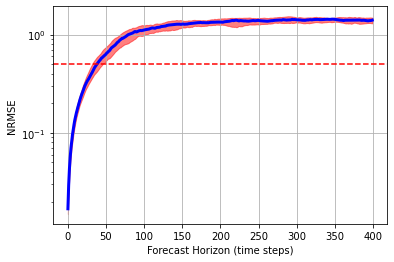

It takes around t = 0.39 for mean error to exceed 0.5


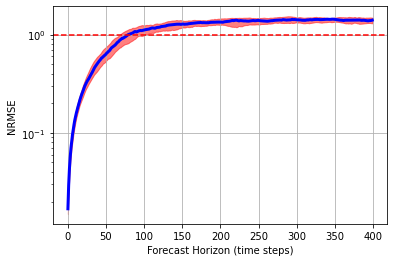

It takes around t = 0.80 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.269
Median NRMSE at t = 0.5: 0.636
Median NRMSE at t = 1: 1.116
Median NRMSE at t = 2: 1.339
Median NRMSE at t = 3: 1.414


In [34]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 6000

In [35]:
nn_size = 6000
lr_list = [1e-4]
epoch_list = [400]

In [36]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 4.86s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.52s
W and W_in generated. Time taken: 8.32s

Generating z values...
z values generated. Time taken: 4.52s
Concatenating z with z**2 Contenation complete. Time taken: 0.93s

Epoch 20: Train time = 0.68 | Train Loss = 0.0004519 
Epoch 40: Train time = 0.69 | Train Loss = 0.0001314 
Epoch 60: Train time = 0.68 | Train Loss = 0.0000515 
Epoch 80: Train time = 0.68 | Train Loss = 0.0000239 
Epoch 100: Train time = 0.69 | Train Loss = 0.0000128 
Epoch 120: Train time = 0.68 | Train Loss = 0.0000080 
Epoch 140: Train time = 0.69 | Train Loss = 0.0000058 
Epoch 160: Train time = 0.68 | Train Loss = 0.0000045 
Epoch 180: Train time = 0.68 | Train Loss = 0.0000037 
Epoch 200: Train time = 0.70 | Train Loss = 0.0000033 
Epoch 220: Train time = 0.68 | Train Loss = 0.0000028 
Epoch 240: Train time = 0.68 | Train Loss = 0.0000025 
Epoch 260: Train time = 0.69 | Train Loss = 0.0000023 
Epoch 280: Train time = 0

In [37]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 115.83


In [38]:
# save_obj(mean_pred, "results/rc", "3_1_2_mu_preds.pkl")

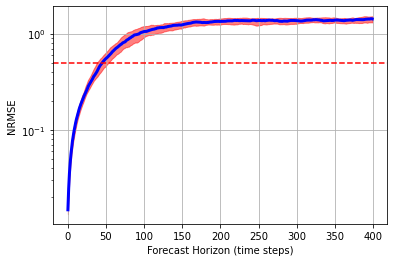

It takes around t = 0.46 for mean error to exceed 0.5


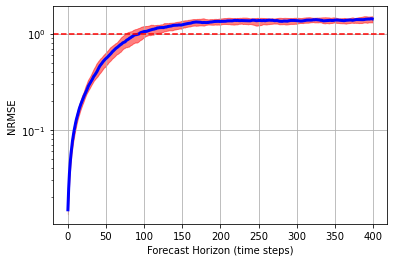

It takes around t = 0.94 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.214
Median NRMSE at t = 0.5: 0.552
Median NRMSE at t = 1: 1.052
Median NRMSE at t = 2: 1.338
Median NRMSE at t = 3: 1.367


In [39]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 9000

In [40]:
nn_size = 9000
lr_list = [1e-4]
epoch_list = [400]

In [41]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 10.46s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.88s
W and W_in generated. Time taken: 14.25s

Generating z values...
z values generated. Time taken: 7.78s
Concatenating z with z**2 Contenation complete. Time taken: 1.47s

Epoch 20: Train time = 1.00 | Train Loss = 0.0002233 
Epoch 40: Train time = 1.00 | Train Loss = 0.0000611 
Epoch 60: Train time = 1.01 | Train Loss = 0.0000242 
Epoch 80: Train time = 1.01 | Train Loss = 0.0000118 
Epoch 100: Train time = 0.99 | Train Loss = 0.0000070 
Epoch 120: Train time = 1.00 | Train Loss = 0.0000052 
Epoch 140: Train time = 1.00 | Train Loss = 0.0000042 
Epoch 160: Train time = 1.01 | Train Loss = 0.0000037 
Epoch 180: Train time = 1.00 | Train Loss = 0.0000032 
Epoch 200: Train time = 1.00 | Train Loss = 0.0000028 
Epoch 220: Train time = 1.00 | Train Loss = 0.0000026 
Epoch 240: Train time = 1.01 | Train Loss = 0.0000025 
Epoch 260: Train time = 1.00 | Train Loss = 0.0000023 
Epoch 280: Train time =

In [42]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 152.18


In [43]:
# save_obj(mean_pred, "results/rc", "3_1_3_mu_preds.pkl")

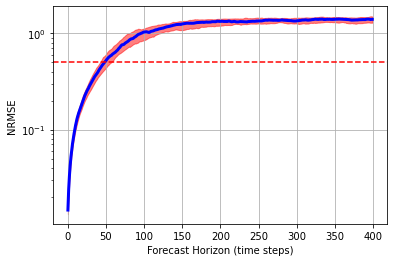

It takes around t = 0.48 for mean error to exceed 0.5


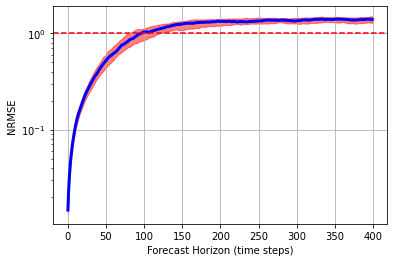

It takes around t = 0.96 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.203
Median NRMSE at t = 0.5: 0.523
Median NRMSE at t = 1: 1.035
Median NRMSE at t = 2: 1.337
Median NRMSE at t = 3: 1.354


In [44]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 12000

In [45]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]

In [46]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 20.24s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.03s
W and W_in generated. Time taken: 26.36s

Generating z values...
z values generated. Time taken: 6.81s
Concatenating z with z**2 Contenation complete. Time taken: 1.36s

Epoch 20: Train time = 1.55 | Train Loss = 0.0001363 
Epoch 40: Train time = 1.55 | Train Loss = 0.0000376 
Epoch 60: Train time = 1.55 | Train Loss = 0.0000154 
Epoch 80: Train time = 1.49 | Train Loss = 0.0000079 
Epoch 100: Train time = 1.48 | Train Loss = 0.0000054 
Epoch 120: Train time = 1.56 | Train Loss = 0.0000047 
Epoch 140: Train time = 1.54 | Train Loss = 0.0000045 
Epoch 160: Train time = 1.55 | Train Loss = 0.0000043 
Epoch 180: Train time = 1.58 | Train Loss = 0.0000037 
Epoch 200: Train time = 1.55 | Train Loss = 0.0000031 
Epoch 220: Train time = 1.54 | Train Loss = 0.0000032 
Epoch 240: Train time = 1.58 | Train Loss = 0.0000032 
Epoch 260: Train time = 1.55 | Train Loss = 0.0000030 
Epoch 280: Train time =

In [47]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 182.93


In [48]:
# save_obj(mean_pred, "results/rc", "3_1_4_mu_preds.pkl")

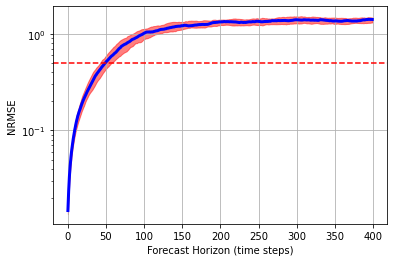

It takes around t = 0.49 for mean error to exceed 0.5


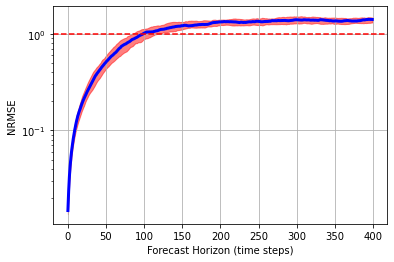

It takes around t = 0.99 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.204
Median NRMSE at t = 0.5: 0.512
Median NRMSE at t = 1: 1.018
Median NRMSE at t = 2: 1.329
Median NRMSE at t = 3: 1.400


In [49]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 nn_size = 15000

In [50]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]

In [51]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 29.27s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.66s
W and W_in generated. Time taken: 36.67s

Generating z values...
z values generated. Time taken: 12.16s
Concatenating z with z**2 Contenation complete. Time taken: 2.34s

Epoch 20: Train time = 1.81 | Train Loss = 0.0000967 
Epoch 40: Train time = 1.81 | Train Loss = 0.0000270 
Epoch 60: Train time = 1.93 | Train Loss = 0.0000115 
Epoch 80: Train time = 1.81 | Train Loss = 0.0000065 
Epoch 100: Train time = 1.85 | Train Loss = 0.0000051 
Epoch 120: Train time = 1.92 | Train Loss = 0.0000056 
Epoch 140: Train time = 1.91 | Train Loss = 0.0000052 
Epoch 160: Train time = 1.91 | Train Loss = 0.0000049 
Epoch 180: Train time = 1.91 | Train Loss = 0.0000042 
Epoch 200: Train time = 1.90 | Train Loss = 0.0000042 
Epoch 220: Train time = 1.86 | Train Loss = 0.0000035 
EARLY STOPPING. Epoch 237: Train loss = 0.0000044
Best Training MSE: 0.0000033
IMPROVED VALIDATION MSE

Total time: 443.76
Complete.

In [52]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 237.21


In [53]:
# save_obj(mean_pred, "results/rc", "3_1_5_mu_preds.pkl")

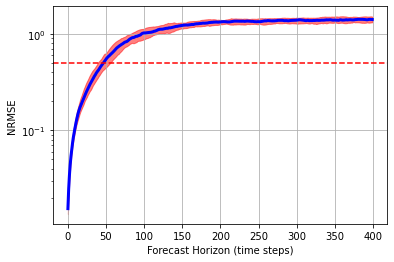

It takes around t = 0.47 for mean error to exceed 0.5


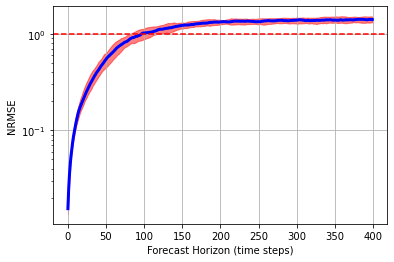

It takes around t = 0.97 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.210
Median NRMSE at t = 0.5: 0.545
Median NRMSE at t = 1: 1.022
Median NRMSE at t = 2: 1.326
Median NRMSE at t = 3: 1.385


In [54]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 lambda (ridge penalty)

**Parameters**
- nn_size = 12000
- connectivity = 4
- spec_radius = 0.5
- lambda = [1e-2, 1e-4, 1e-6]

In [55]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]

### 3.2.1 lambda = 1e-2

In [56]:
ridge_penalty = 1e-2

In [57]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 20.51s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.86s
W and W_in generated. Time taken: 26.64s

Generating z values...
z values generated. Time taken: 8.65s
Concatenating z with z**2 Contenation complete. Time taken: 1.45s

Epoch 20: Train time = 1.60 | Train Loss = 0.0001366 
Epoch 40: Train time = 1.61 | Train Loss = 0.0000379 
Epoch 60: Train time = 1.61 | Train Loss = 0.0000157 
Epoch 80: Train time = 1.61 | Train Loss = 0.0000083 
Epoch 100: Train time = 1.63 | Train Loss = 0.0000057 
Epoch 120: Train time = 1.59 | Train Loss = 0.0000050 
Epoch 140: Train time = 1.62 | Train Loss = 0.0000048 
Epoch 160: Train time = 1.61 | Train Loss = 0.0000046 
Epoch 180: Train time = 1.64 | Train Loss = 0.0000040 
Epoch 200: Train time = 1.58 | Train Loss = 0.0000034 
Epoch 220: Train time = 1.59 | Train Loss = 0.0000035 
Epoch 240: Train time = 1.60 | Train Loss = 0.0000035 
Epoch 260: Train time = 1.59 | Train Loss = 0.0000033 
Epoch 280: Train time =

In [58]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 196.01


In [59]:
# save_obj(mean_pred, "results/rc", "3_2_1_mu_preds.pkl")

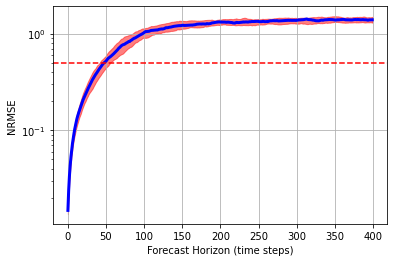

It takes around t = 0.48 for mean error to exceed 0.5


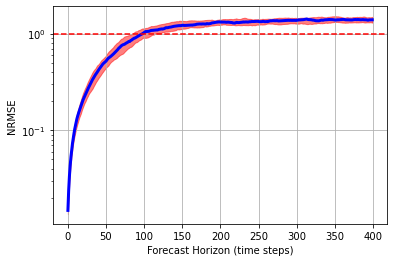

It takes around t = 0.99 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.208
Median NRMSE at t = 0.5: 0.519
Median NRMSE at t = 1: 1.025
Median NRMSE at t = 2: 1.316
Median NRMSE at t = 3: 1.372


In [60]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 lambda = 1e-4
Already done is 3.1.4

### 3.2.3 lambda = 1e-6

In [61]:
ridge_penalty = 1e-6

In [62]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 19.58s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 4.31s
W and W_in generated. Time taken: 27.16s

Generating z values...
z values generated. Time taken: 6.86s
Concatenating z with z**2 Contenation complete. Time taken: 1.40s

Epoch 20: Train time = 1.59 | Train Loss = 0.0001364 
Epoch 40: Train time = 1.59 | Train Loss = 0.0000376 
Epoch 60: Train time = 1.61 | Train Loss = 0.0000154 
Epoch 80: Train time = 1.60 | Train Loss = 0.0000079 
Epoch 100: Train time = 1.59 | Train Loss = 0.0000054 
Epoch 120: Train time = 1.59 | Train Loss = 0.0000047 
Epoch 140: Train time = 1.59 | Train Loss = 0.0000045 
Epoch 160: Train time = 1.59 | Train Loss = 0.0000043 
Epoch 180: Train time = 1.58 | Train Loss = 0.0000037 
Epoch 200: Train time = 1.59 | Train Loss = 0.0000031 
Epoch 220: Train time = 1.59 | Train Loss = 0.0000032 
Epoch 240: Train time = 1.60 | Train Loss = 0.0000032 
Epoch 260: Train time = 1.60 | Train Loss = 0.0000030 
Epoch 280: Train time =

In [63]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 197.29


In [64]:
# save_obj(mean_pred, "results/rc", "3_2_3_mu_preds.pkl")

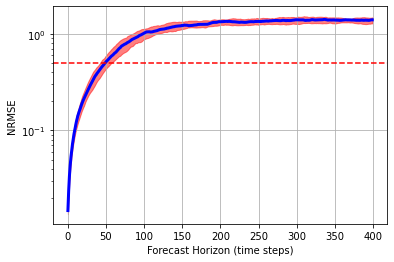

It takes around t = 0.49 for mean error to exceed 0.5


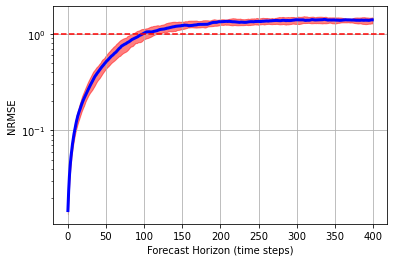

It takes around t = 0.99 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.205
Median NRMSE at t = 0.5: 0.513
Median NRMSE at t = 1: 1.017
Median NRMSE at t = 2: 1.332
Median NRMSE at t = 3: 1.396


In [65]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 spec_radius

**Parameters**
- nn_size = 12000
- connectivity = 4
- spec_radius = [0.1, 0.3, 0.5, 0.7]
- lambda = 1e-6

In [67]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]
ridge_penalty = 1e-4

### 3.3.1 spec_radius = 0.1

In [68]:
spec_radius = 0.1

In [69]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 19.20s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.46s
W and W_in generated. Time taken: 23.82s

Generating z values...
z values generated. Time taken: 10.22s
Concatenating z with z**2 Contenation complete. Time taken: 1.41s

Epoch 20: Train time = 1.59 | Train Loss = 0.0001254 
Epoch 40: Train time = 1.50 | Train Loss = 0.0000337 
Epoch 60: Train time = 1.59 | Train Loss = 0.0000131 
Epoch 80: Train time = 1.61 | Train Loss = 0.0000063 
Epoch 100: Train time = 1.58 | Train Loss = 0.0000039 
Epoch 120: Train time = 1.61 | Train Loss = 0.0000032 
Epoch 140: Train time = 1.59 | Train Loss = 0.0000032 
Epoch 160: Train time = 1.59 | Train Loss = 0.0000033 
Epoch 180: Train time = 1.59 | Train Loss = 0.0000029 
Epoch 200: Train time = 1.59 | Train Loss = 0.0000025 
Epoch 220: Train time = 1.58 | Train Loss = 0.0000023 
Epoch 240: Train time = 1.59 | Train Loss = 0.0000023 
Epoch 260: Train time = 1.59 | Train Loss = 0.0000023 
EARLY STOPPING. Epoch 

In [70]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 195.13


In [71]:
# save_obj(mean_pred, "results/rc", "3_3_1_mu_preds.pkl")

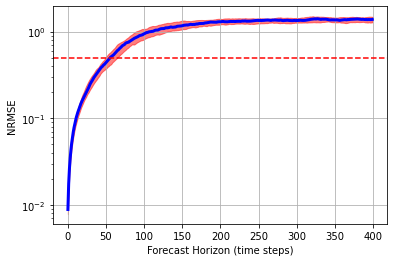

It takes around t = 0.56 for mean error to exceed 0.5


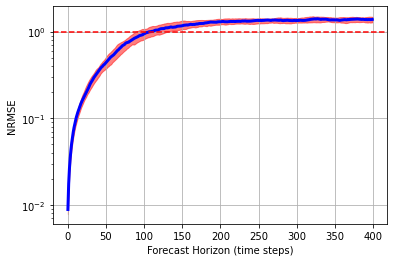

It takes around t = 1.09 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.168
Median NRMSE at t = 0.5: 0.440
Median NRMSE at t = 1: 0.944
Median NRMSE at t = 2: 1.300
Median NRMSE at t = 3: 1.342


In [72]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.2 spec_radius = 0.3

In [73]:
spec_radius = 0.3

In [74]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 21.34s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.33s
W and W_in generated. Time taken: 27.94s

Generating z values...
z values generated. Time taken: 9.94s
Concatenating z with z**2 Contenation complete. Time taken: 1.76s

Epoch 20: Train time = 1.57 | Train Loss = 0.0001277 
Epoch 40: Train time = 1.58 | Train Loss = 0.0000346 
Epoch 60: Train time = 1.57 | Train Loss = 0.0000137 
Epoch 80: Train time = 1.60 | Train Loss = 0.0000067 
Epoch 100: Train time = 1.59 | Train Loss = 0.0000043 
Epoch 120: Train time = 1.58 | Train Loss = 0.0000035 
Epoch 140: Train time = 1.58 | Train Loss = 0.0000036 
Epoch 160: Train time = 1.58 | Train Loss = 0.0000036 
Epoch 180: Train time = 1.58 | Train Loss = 0.0000031 
Epoch 200: Train time = 1.59 | Train Loss = 0.0000026 
Epoch 220: Train time = 1.58 | Train Loss = 0.0000026 
Epoch 240: Train time = 1.57 | Train Loss = 0.0000026 
Epoch 260: Train time = 1.59 | Train Loss = 0.0000025 
Epoch 280: Train time =

In [75]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 190.13


In [76]:
# save_obj(mean_pred, "results/rc", "3_3_2_mu_preds.pkl")

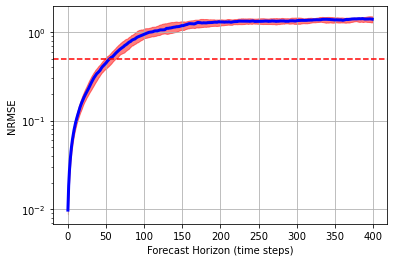

It takes around t = 0.55 for mean error to exceed 0.5


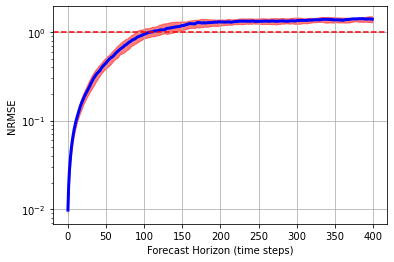

It takes around t = 1.09 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.175
Median NRMSE at t = 0.5: 0.449
Median NRMSE at t = 1: 0.943
Median NRMSE at t = 2: 1.299
Median NRMSE at t = 3: 1.344


In [77]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 spec_radius = 0.5
Already done in 3.2.2 / 3.1.4

### 3.3.4 spec_radius = 0.7

In [78]:
spec_radius = 0.7

In [79]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 19.39s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.81s
W and W_in generated. Time taken: 25.37s

Generating z values...
z values generated. Time taken: 8.42s
Concatenating z with z**2 Contenation complete. Time taken: 1.38s

Epoch 20: Train time = 1.58 | Train Loss = 0.0001571 
Epoch 40: Train time = 1.58 | Train Loss = 0.0000458 
Epoch 60: Train time = 1.56 | Train Loss = 0.0000203 
Epoch 80: Train time = 1.58 | Train Loss = 0.0000116 
Epoch 100: Train time = 1.57 | Train Loss = 0.0000083 
Epoch 120: Train time = 1.56 | Train Loss = 0.0000072 
Epoch 140: Train time = 1.57 | Train Loss = 0.0000066 
Epoch 160: Train time = 1.56 | Train Loss = 0.0000056 
Epoch 180: Train time = 1.56 | Train Loss = 0.0000048 
Epoch 200: Train time = 1.57 | Train Loss = 0.0000041 
Epoch 220: Train time = 1.57 | Train Loss = 0.0000046 
Epoch 240: Train time = 1.57 | Train Loss = 0.0000041 
Epoch 260: Train time = 1.57 | Train Loss = 0.0000044 
Epoch 280: Train time =

In [80]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 186.57


In [81]:
# save_obj(mean_pred, "results/rc", "3_3_4_mu_preds.pkl")

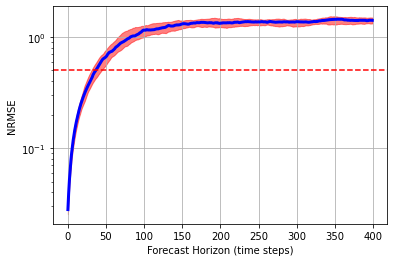

It takes around t = 0.37 for mean error to exceed 0.5


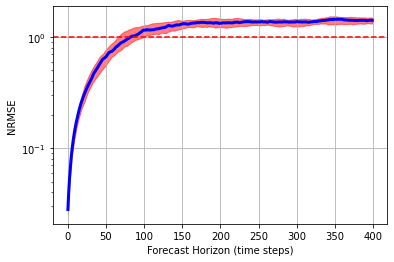

It takes around t = 0.82 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.288
Median NRMSE at t = 0.5: 0.665
Median NRMSE at t = 1: 1.151
Median NRMSE at t = 2: 1.330
Median NRMSE at t = 3: 1.373


In [82]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.4 connectivity

**Parameters**
- nn_size = 12000
- connectivity = [4, 8]
- spec_radius = ?
- lambda = 1e-6

In [83]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]
ridge_penalty = 1e-4
spec_radius = 0.1

### 3.4.1 connectivity = 4 
Already done in Section 3.3.1

### 3.4.2 connectivity = 8

In [84]:
connectivity = 8

In [85]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 18.85s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 10.33s
W and W_in generated. Time taken: 32.46s

Generating z values...
z values generated. Time taken: 8.71s
Concatenating z with z**2 Contenation complete. Time taken: 1.36s

Epoch 20: Train time = 1.45 | Train Loss = 0.0001210 
Epoch 40: Train time = 1.59 | Train Loss = 0.0000323 
Epoch 60: Train time = 1.59 | Train Loss = 0.0000126 
Epoch 80: Train time = 1.59 | Train Loss = 0.0000061 
Epoch 100: Train time = 1.59 | Train Loss = 0.0000038 
Epoch 120: Train time = 1.61 | Train Loss = 0.0000032 
Epoch 140: Train time = 1.59 | Train Loss = 0.0000031 
Epoch 160: Train time = 1.61 | Train Loss = 0.0000028 
Epoch 180: Train time = 1.58 | Train Loss = 0.0000028 
Epoch 200: Train time = 1.60 | Train Loss = 0.0000025 
Epoch 220: Train time = 1.59 | Train Loss = 0.0000026 
Epoch 240: Train time = 1.60 | Train Loss = 0.0000023 
Epoch 260: Train time = 1.62 | Train Loss = 0.0000024 
Epoch 280: Train time 

In [86]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 215.12


In [87]:
# save_obj(mean_pred, "results/rc", "3_4_2_mu_preds.pkl")

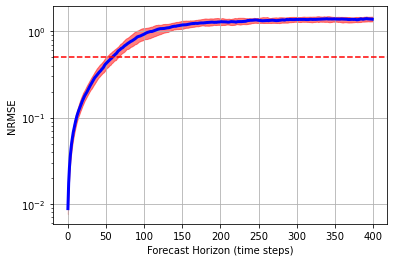

It takes around t = 0.59 for mean error to exceed 0.5


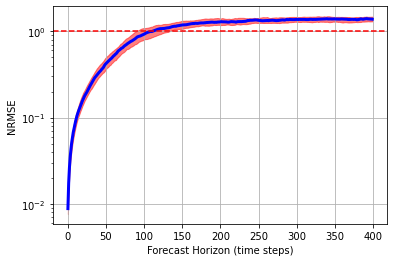

It takes around t = 1.11 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.164
Median NRMSE at t = 0.5: 0.424
Median NRMSE at t = 1: 0.926
Median NRMSE at t = 2: 1.288
Median NRMSE at t = 3: 1.372


In [88]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best model
nn_size = 12000  
beta = 1e-6  
connectivity = 4  
spec_radius = 0.1

In [89]:
nn_size = 12000
ridge_penalty = 1e-4
spec_radius = 0.1
connectivity = 8

lr_list = [1e-4]
epoch_list = [400]

transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

In [90]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 19.44s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 15.52s
W and W_in generated. Time taken: 38.32s

Generating z values...
z values generated. Time taken: 10.40s
Concatenating z with z**2 Contenation complete. Time taken: 1.76s

Epoch 20: Train time = 1.50 | Train Loss = 0.0001210 
Epoch 40: Train time = 1.50 | Train Loss = 0.0000323 
Epoch 60: Train time = 1.60 | Train Loss = 0.0000126 
Epoch 80: Train time = 1.57 | Train Loss = 0.0000061 
Epoch 100: Train time = 1.57 | Train Loss = 0.0000038 
Epoch 120: Train time = 1.58 | Train Loss = 0.0000032 
Epoch 140: Train time = 1.58 | Train Loss = 0.0000031 
Epoch 160: Train time = 1.57 | Train Loss = 0.0000028 
Epoch 180: Train time = 1.57 | Train Loss = 0.0000028 
Epoch 200: Train time = 1.57 | Train Loss = 0.0000025 
Epoch 220: Train time = 1.59 | Train Loss = 0.0000026 
Epoch 240: Train time = 1.56 | Train Loss = 0.0000023 
Epoch 260: Train time = 1.57 | Train Loss = 0.0000024 
Epoch 280: Train time

In [91]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 197.05


In [92]:
save_obj(mean_pred, "results/rc", "best_mu_preds.pkl")
save_obj(W, "results/rc", "best_W.pkl")
save_obj(W_in, "results/rc", "best_W_in.pkl")
save_obj(params, "results/rc", "best_params.pkl")

In [142]:
# W = load_obj("results/rc/best_W.pkl")
# W_in = load_obj("results/rc/best_W_in.pkl")
# params = load_obj("results/rc/best_params.pkl")

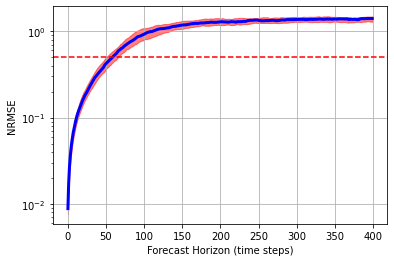

It takes around t = 0.59 for mean error to exceed 0.5


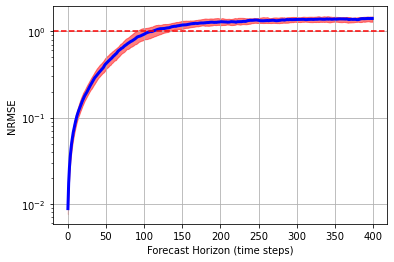

It takes around t = 1.11 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.164
Median NRMSE at t = 0.5: 0.424
Median NRMSE at t = 1: 0.926
Median NRMSE at t = 2: 1.289
Median NRMSE at t = 3: 1.371


In [93]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

**check disk space**

In [112]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

print(get_size("results/rc") / (2**30), 'GiB')

0.08522220607846975 GiB


In [113]:
import shutil

total, used, free = shutil.disk_usage("/")

print("Total: %d GiB" % (total // (2**30)))
print("Used: %d GiB" % (used // (2**30)))
print("Free: %d GiB" % (free // (2**30)))

Total: 192 GiB
Used: 173 GiB
Free: 9 GiB


# 5. Plot images based on Lyapunov Time

In [94]:
mean_pred = load_obj("results/rc/best_mu_preds.pkl")

In [11]:
# save_obj(mean_pred, "results", "rc_pred.pkl")

In [95]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

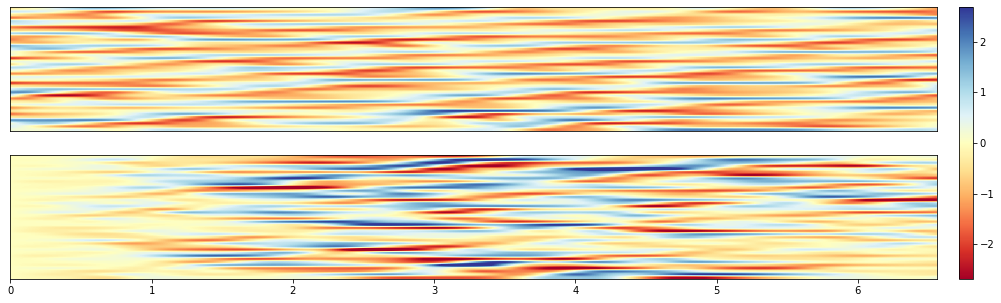

In [96]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_vsmall_rc", pred_only=True)

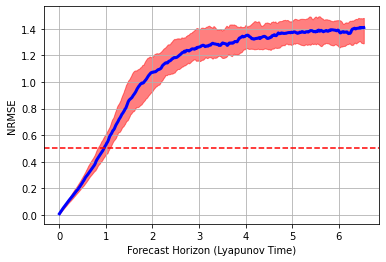

It takes around 0.97 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.241
Median NRMSE at 1.0 Lyapunov Time: 0.527
Median NRMSE at 2.0 Lyapunov Time: 1.074
Median NRMSE at 5.0 Lyapunov Time: 1.372


In [97]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "lorenz_vsmall_rc_ph")
print()
res_single.get_loss()